In [1]:
# 기본 라이브러리 임포트
import pandas as pd             
import numpy as np             
import matplotlib.pyplot as plt 
import seaborn as sns           
import gc                       # 가비지 컬렉션(메모리 해제)
import re                       # 정규 표현식 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')   

# 그래프 스타일 설정
sns.set()                           # seaborn 기본 스타일 적용

# matplotlib 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['figure.figsize'] = (12, 6)       # 그림 크기 설정 (가로, 세로)
plt.rcParams['font.size'] = 14                 # 폰트 크기 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 결측치 시각화 라이브러리 임포트
import missingno                          # 결측치 분포를 시각화하는 유틸리티

# 범주형 변수 레이블 인코딩을 위한 도구 임포트
from sklearn.preprocessing import LabelEncoder

# 중복 조합 생성에 사용할 product 함수 임포트
from itertools import product

# 회귀 및 통계 분석을 위한 statsmodels 임포트
import statsmodels.api as sm

# 다중공선성 진단용 VIF 계산 함수 임포트
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# VIF로 제거된 피처들만 (PCA 대상)
train_removed_df = pd.read_csv("removed_features.csv")
test_removed_df  = pd.read_csv("test_removed_features.csv")

# VIF로 살아남은 피처들만 (그대로 사용할 입력)
train_selected_df = pd.read_csv("selected_features.csv")        # ID, Segment 포함
test_selected_df  = pd.read_csv("test_selected_features.csv")   # ID, Segment 포함


# PCA 적용을 위한 병합
train_removed_df['__is_train__'] = 1
test_removed_df['__is_train__'] = 0
removed_merged = pd.concat([train_removed_df, test_removed_df], ignore_index=True)

# 스케일링
X_scaled = StandardScaler().fit_transform(removed_merged.drop(columns='__is_train__').fillna(0))


# 7. PCA 학습
pca = PCA()
pca.fit(X_scaled)

PCA()

📌 Elbow 기준 주성분 개수: 98


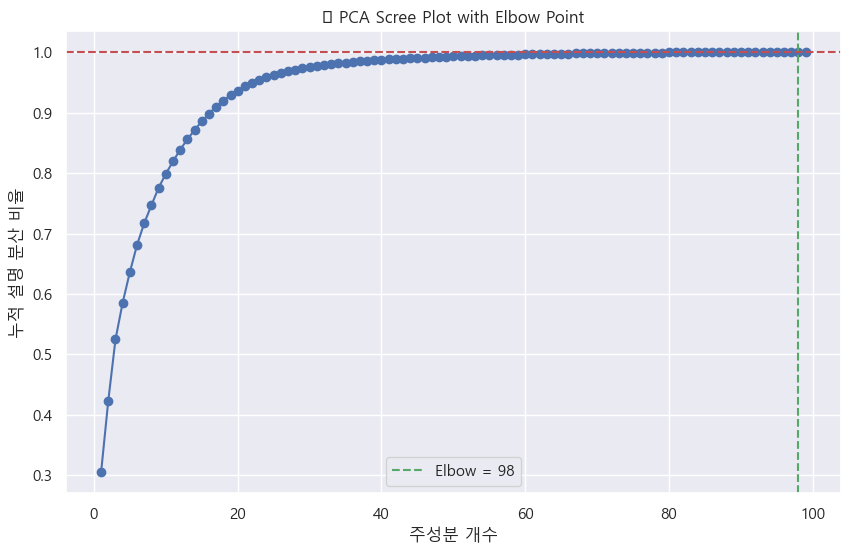

In [3]:
# 누적 설명 분산 계산 및 엘보우 포인트 탐색
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
second_diff = np.diff(cumulative_var, n=2)
elbow_index = np.argmax(second_diff) + 2
print("📌 Elbow 기준 주성분 개수:", elbow_index)

# Scree Plot 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.axvline(x=elbow_index, color='g', linestyle='--', label=f'Elbow = {elbow_index}')
plt.axhline(y=cumulative_var[elbow_index - 1], color='r', linestyle='--')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산 비율')
plt.title('📊 PCA Scree Plot with Elbow Point')
plt.grid(True)
plt.legend()
plt.show()

# 주성분 변환 (elbow 기준)
pca_final = PCA(n_components=elbow_index)
X_pca_reduced = pca_final.fit_transform(X_scaled)

#  주성분 결과 데이터프레임 생성
pca_cols = [f'PC{i+1}' for i in range(elbow_index)]
pca_df = pd.DataFrame(X_pca_reduced, columns=pca_cols)
pca_df['__is_train__'] = removed_merged['__is_train__'].reset_index(drop=True)

In [4]:
# train/test로 다시 분리
train_pca_df = pca_df[pca_df['__is_train__'] == 1].drop(columns='__is_train__').reset_index(drop=True)
test_pca_df  = pca_df[pca_df['__is_train__'] == 0].drop(columns='__is_train__').reset_index(drop=True)

# VIF 통과 피처들과 PCA 결과 병합
final_train_df = pd.concat([train_selected_df.reset_index(drop=True), train_pca_df], axis=1)
final_test_df  = pd.concat([test_selected_df.reset_index(drop=True), test_pca_df], axis=1)

In [8]:
# 저장
final_train_df.to_csv("train_final_with_pca.csv", index=False, encoding='utf-8-sig')
final_test_df.to_csv("test_final_with_pca.csv", index=False, encoding='utf-8-sig')